<a href="https://colab.research.google.com/github/Abd-elr4hman/DeepLearning/blob/main/Predicting_Bounding_Boxes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Bounding Boxes
Contents:

Building a model to predict bounding boxes around images.  
using transfer learning on Mobelnet pre-trained model available in Keras. 
- Using the [Caltech Birds - 2010](http://www.vision.caltech.edu/visipedia/CUB-200.html) dataset. 

<a name="0-2"></a>
## Set up the data location
A copy of the dataset used here is stored in a publicly viewable Google Drive folder.  You'll want to add a shortcut to it to your own Google Drive.
- Go to this google drive folder named [TF3 C3 W1 Data](https://drive.google.com/drive/folders/1xgqUw9uWzL5Kh88iPdX1TBQgnkc-wVKd?usp=sharing)
- Next to the folder name "TF3 C3 W1 Data" (at the top of the page beside "Shared with me"), hover your mouse over the triangle to reveal the drop down menu. 
- Use the drop down menu to select `"Add shortcut to Drive"`  A pop-up menu will open up. 
- In the pop-up menu, "My Drive" is selected by default.  Click the `ADD SHORTCUT` button. This should add a shortcut to the folder `TF3 C3 W1 Data` within your own google drive at the location `content/drive`.
- To verify, go to the left-side menu and click on "My Drive".  Scroll through your files to look for the shortcut TF3 C3 W1 Data.  

Please make sure this happens, as you'll be reading the data for this notebook from this folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

In [ ]:
data_dir = "/content/drive/My Drive/TF3 C3 W1 Data/"

<a name="1"></a>
## 1. Visualization Utilities

<a name="1-1"></a>
### 1.1 Bounding Boxes Utilities

These functions were found online and i didn't implement it, used to ease the proccess of dealing with the dataset 

- `draw_bounding_box_on_image`: Draws a single bounding box on an image.
- `draw_bounding_boxes_on_image`: Draws multiple bounding boxes on an image.
- `draw_bounding_boxes_on_image_array`: Draws multiple bounding boxes on an array of images.

In [ ]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    
    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.
    
    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
                           
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).
    
    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.
    
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image

<a name="1-2"></a>
### 1.2 Data and Predictions Utilities

helper functions and code that are used to visualize the data and the model's predictions.

- `display_digits_with_boxes`: This displays a row of "digit" images along with the model's predictions for each image.
- `plot_metrics`: This plots a given metric (like loss) as it changes over multiple epochs of training.  

In [ ]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)
        
        
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

<a name="2"></a>
## 2. Preprocess and Load the Dataset

<a name="2-1"></a>
### 2.1 Preprocessing Utilities

some helper functions to pre-process the image data.

#### read_image_tfds
- Resizes `image` to (224, 224)
- Normalizes `image`
- Translates and normalizes bounding boxes

In [ ]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    
    return image, bbox_list

#### read_image_with_shape
This is very similar to `read_image_tfds` except it also keeps a copy of the original image (before pre-processing) and returns this as well.
- Makes a copy of the original image.
- Resizes `image` to (224, 224)
- Normalizes `image`
- Translates and normalizes bounding boxes

In [ ]:
def read_image_with_shape(image, bbox):
    original_image = image
    
    image, bbox_list = read_image_tfds(image, bbox)
    
    return original_image, image, bbox_list

#### read_image_tfds_with_original_bbox

- This function reads `image` from `data`
- It also denormalizes the bounding boxes (it undoes the bounding box normalization that is performed by the previous two helper functions.)

In [ ]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]
    return image, bbox_list

#### dataset_to_numpy_util
This function converts a `dataset` into numpy arrays of images and boxes.
- This will be used when visualizing the images and their bounding boxes

In [ ]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

#### dataset_to_numpy_with_original_bboxes_util

- This function converts a `dataset` into numpy arrays of 
  - original images
  - resized and normalized images
  - bounding boxes
- This will be used for plotting the original images with true and predicted bounding boxes.

In [ ]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

<a name="2-2"></a>
### 2.2 Visualize the images and their bounding box labels
Now you'll take a random sample of images from the training and validation sets and visualize them by plotting the corresponding bounding boxes.

Visualize the **training** images and their bounding box labels

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    version=0.1.1,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=6033,
    splits={
        'test': 3033,
        'train': 3000,
    },
    supervised_keys=('ima

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


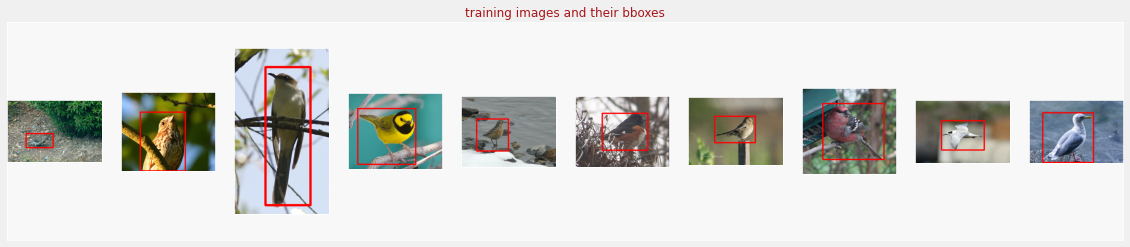

In [ ]:
def get_visualization_training_dataset():      
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir, download=False)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, 
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()


(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

Visualize the **validation** images and their bounding boxes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


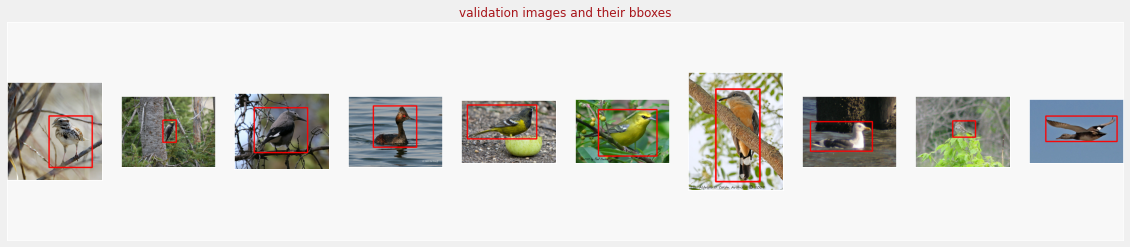

In [ ]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", data_dir=data_dir, download=False)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

<a name="2-3"></a>
### 2.3 Load and prepare the datasets for the model

These next two functions read and prepare the datasets that will be fed to the model.
- They use `read_image_tfds` to resize, and normalize each image and its bounding box label.
- They performs shuffling and batching.
- You'll use these functions to create `training_dataset` and `validation_dataset`, which you will give to the model that you're about to build.

In [ ]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

<a name="3"></a>
## 3. Define the Network

Bounding box prediction is treated as a "regression" task, which means that we want the model to output numerical values.

- we will be performing transfer learning with **MobileNet V2**.  The model architecture is available in TensorFlow Keras.
- we'll also use pretrained `'imagenet'` weights as a starting point for further training.  These weights are also readily available 
- we will choose to retrain all layers of **MobileNet V2** along with the final classification layers.


In [ ]:
def feature_extractor(inputs):
    
    
    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
    

    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)
    

   
        
    # return the feature_extractor
    return feature_extractor

In [ ]:
def dense_layers(features):
    

    # global average pooling 2D layer.
    x = tf.keras.layers.GlobalAveragePooling2D()(features) 
    
    # flatten layer
    x = tf.keras.layers.Flatten()(x)
    
    # 1024 Dense layer, with relu
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    
    # 512 Dense layer, with relu
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    
   
    
    return x

In [ ]:
def bounding_box_regression(x):
    
    
    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(units = '4', name = 'bounding_box')(x)

    
        

    return bounding_box_regression_output

In [ ]:
def final_model(inputs):
    

    # features
    feature_cnn = feature_extractor(inputs)

    # dense layers
    last_dense_layer = dense_layers(feature_cnn)

    # bounding box
    bounding_box_output = bounding_box_regression(last_dense_layer)
    
    # define the TensorFlow Keras model using the inputs and outputs to your model
    model = tf.keras.Model(inputs = inputs, outputs =  bounding_box_output)

   
    
    
    return model

In [ ]:
def define_and_compile_model():
  
   

    # define the input layer
    inputs = tf.keras.Input(shape=(224,224,3,))
    
    # create the model
    model = final_model(inputs)
    
    # compile model
    model.compile(optimizer='adam', 
              loss =  'mse',
              metrics =  'mse')

    
    

    return model

In [ ]:
# define model
model = define_and_compile_model()
# print model layers
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
________________________________________________________________

<a name='4'></a>
## Train the Model

In [ ]:
# You'll train 50 epochs
EPOCHS = 50

### START CODE HERE ###

# Choose a batch size
BATCH_SIZE = 30

# Get the length of the training set
length_of_training_dataset = len(visualization_training_dataset)

# Get the length of the validation set
length_of_validation_dataset = len(visualization_validation_dataset)

# Get the steps per epoch (may be a few lines of code)
steps_per_epoch = 100

# get the validation steps (per epoch) (may be a few lines of code)
validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1
    
### END CODE HERE

In [ ]:
### YOUR CODE HERE ####

# Fit the model, setting the parameters noted in the instructions above.
history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

### END CODE HERE ###

Epoch 1/50
100/100 [==============================] - 142s 1s/step - loss: 0.2099 - mse: 0.2099 - val_loss: 575.0310 - val_mse: 575.0310
Epoch 2/50
100/100 [==============================] - 103s 1s/step - loss: 0.0085 - mse: 0.0085 - val_loss: 349.3109 - val_mse: 349.3109
Epoch 3/50
100/100 [==============================] - 103s 1s/step - loss: 0.0053 - mse: 0.0053 - val_loss: 181.8159 - val_mse: 181.8159
Epoch 4/50
100/100 [==============================] - 104s 1s/step - loss: 0.0038 - mse: 0.0038 - val_loss: 88.5211 - val_mse: 88.5211
Epoch 5/50
100/100 [==============================] - 104s 1s/step - loss: 0.0032 - mse: 0.0032 - val_loss: 45.7526 - val_mse: 45.7526
Epoch 6/50
100/100 [==============================] - 105s 1s/step - loss: 0.0024 - mse: 0.0024 - val_loss: 20.4409 - val_mse: 20.4409
Epoch 7/50
100/100 [==============================] - 104s 1s/step - loss: 0.0023 - mse: 0.0023 - val_loss: 9.7754 - val_mse: 9.7754
Epoch 8/50
100/100 [==============================]

<a name='5'></a>
## 5. Validate the Model

<a name='5-1'></a>
### 5.1 Loss

 now evaluate  trained model's performance by checking its loss value on the validation set.

In [ ]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

102/102 [==============================] - 33s 324ms/step - loss: 0.0272 - mse: 0.0272
Loss:  [0.027150997892022133, 0.027150997892022133]


<a name=''></a>
###  Plot Loss Function

 plot the loss metrics.

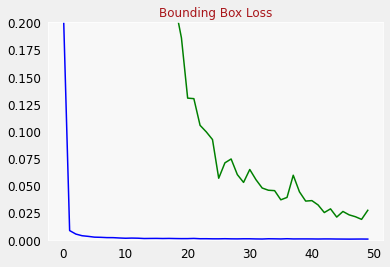

In [ ]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

<a name=''></a>
### Evaluate performance using IoU

 see how well  model predicts bounding boxes on the validation set by calculating the Intersection-over-union (IoU) score for each image.


In [ ]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Number of predictions where iou > threshold(0.5): 164
Number of predictions where iou < threshold(0.5): 336


##  Visualize Predictions

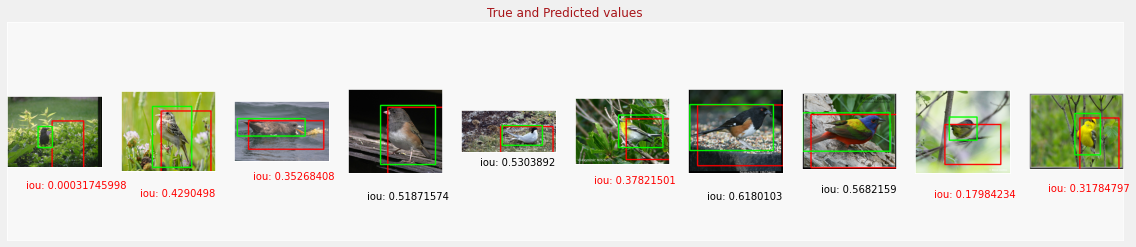

In [ ]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)